In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data preprocessing and feature eng

In [2]:
df_Trans=pd.read_csv(r"/kaggle/input/ibm-transactions-for-anti-money-laundering-aml//HI-Small_Trans.csv")
df_Banks=pd.read_csv(r"/kaggle/input/ibm-transactions-for-anti-money-laundering-aml//HI-Small_accounts.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/ibm-transactions-for-anti-money-laundering-aml//HI-Small_Trans.csv'

In [ ]:
data=df_Trans.copy()
details=df_Banks.copy()
del df_Trans,df_Banks

In [ ]:
data['Timestamp']=pd.to_datetime(data['Timestamp'], format='%Y/%m/%d %H:%M')

In [ ]:
data["Is Laundering"].value_counts(normalize=True)*100

Is Laundering
0    99.898057
1     0.101943
Name: proportion, dtype: float64

In [ ]:
# Removing those banks where no Laundering occured
counts =data.groupby(['From Bank', 'Is Laundering']).size().unstack(fill_value=0)
banks_no_laundering = counts.loc[counts.get(1, 0) == 0].index.tolist()
data = data[~data['From Bank'].isin(banks_no_laundering)]

In [ ]:
data["Is Laundering"].value_counts(normalize=True)*100

Is Laundering
0    99.885924
1     0.114076
Name: proportion, dtype: float64

In [ ]:
data['weekday'] = data['Timestamp'].dt.weekday
data['hour'] = data['Timestamp'].dt.hour

In [ ]:
# If sender is same as reciever then self else out 
data['Type'] = np.where(data['Account'] == data['Account.1'],'self', 'out')

In [ ]:
# keeping a count of transactions done over the period by each account
data = data.sort_values('Timestamp')
data['sender_txn_overall_count'] = data.groupby('Account').cumcount() + 1
data['reciever_txn_overall_count'] = data.groupby('Account.1').cumcount() + 1

# keeping a count of transactions done daily by each account
data['sender_txn_daily_count'] = data.groupby(['Account','weekday']).cumcount() + 1
data['reciever_txn_daily_count'] = data.groupby(['Account.1','weekday']).cumcount() + 1

In [ ]:
# cleaning the bank details

details['Entity Name']=details['Entity Name'].str.split(' #').str[0]
details['Bank Name']=details['Bank Name'].str.split(' #').str[0]

In [ ]:
# Merging data and details
newdf=pd.merge(data,details,left_on='Account',right_on='Account Number')
newdf.drop(columns=['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1','Bank ID','Account Number','Entity ID'],inplace=True)


# Pipeline for transformations

In [ ]:
numerical_cols = newdf.select_dtypes(include=np.number).drop(['Is Laundering','weekday','hour'], axis=1).columns.tolist()
OHE_cols =['Receiving Currency','Payment Currency','Payment Format','Type','Entity Name','weekday','hour']
Bin_cols=['Bank Name']

In [ ]:
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce

def create_preprocessor(numerical_cols,OHE_cols,Bin_cols):
    numeric_transformer = SklearnPipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer1 = SklearnPipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        #('Label', OrdinalEncoder())
    ])
    categorical_transformer2 = SklearnPipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('binary_enc', ce.BinaryEncoder(drop_invariant=True   ))])
        
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_cols),
            ('cat1', categorical_transformer1, OHE_cols),
            ('cat2', categorical_transformer2, Bin_cols)
        ], remainder='drop'
    )
    return preprocessor

In [ ]:
preproc=create_preprocessor(numerical_cols, OHE_cols, Bin_cols)

In [ ]:
X_transformed = preproc.fit_transform(newdf.drop('Is Laundering', axis=1))

# SMOTE

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_transformed, newdf['Is Laundering'],train_size=0.7)

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(k_neighbors=10)

X_train_smote,y_train_smote=smote.fit_resample(X_train,y_train)

# MODEL

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


dtrain = xgb.DMatrix(X_train_smote, label=y_train_smote)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
params = {
    "objective": "binary:logistic",   # binary classification
    "eval_metric": "auc",             # evaluation metric
    "eta": 0.039,                       # learning rate
    "max_depth": 6,                   # max tree depth
    "subsample": 0.5,                 # row sampling
    "colsample_bytree": 0.5,          # feature sampling
    "seed": 42,
    "n_estimators": 331,
    
}

In [ ]:
MAX_ROUNDS = 500 
EARLY_STOP = 50 
OPT_ROUNDS = 1000  
VERBOSE_EVAL = 50


In [ ]:
watchlist = [(dtrain, "train"), (dtest, "eval")]

In [ ]:
model = xgb.train(
    params,
    dtrain,
    MAX_ROUNDS,
    watchlist,
    early_stopping_rounds=EARLY_STOP,
    maximize=True,
    verbose_eval=VERBOSE_EVAL
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [05:06:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-auc:0.89863	eval-auc:0.78401
[50]	train-auc:0.98969	eval-auc:0.96823
[100]	train-auc:0.99451	eval-auc:0.97090
[150]	train-auc:0.99781	eval-auc:0.97088
[166]	train-auc:0.99838	eval-auc:0.97091


In [ ]:
y_pred = model.predict(dtest)
y_pred_label = (y_pred > 0.5).astype(int)

# 8. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_label))

Accuracy: 0.9592448467541015


# Evalution and confusion matrix

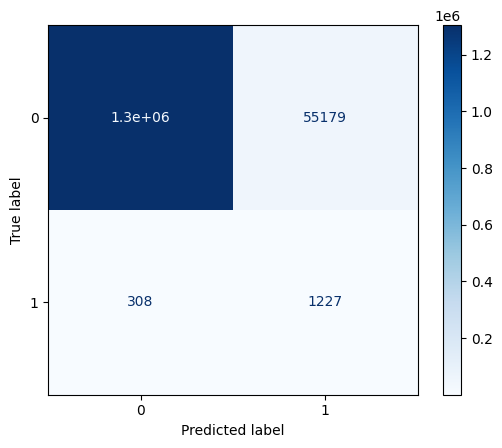

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc_score(y_test, y_pred)

0.9709083436440755